# UCF101 Training on normal DNN

In [1]:
#importing the libraries we need
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchvision
import cv2
from torch.utils.data import Dataset, DataLoader
from torch import nn
import re
from torch.autograd import Variable

from utils import *
from  models.FFNNModel import FFNNModel
from models.trainFFNN import trainNN

torch.cuda.empty_cache()


In [2]:
#assigning the type of device that we will work on
#device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device =  torch.device('cpu')

In [3]:
#loading the names of the frames and thier classes
train_frames = pd.read_csv('frames_train_1.csv') 
test_frames = pd.read_csv('frames_test_1.csv') 

train_videos = pd.read_csv('video_train_1.csv') 
test_videos = pd.read_csv('video_test_1_classes.csv')

In [4]:
train_frames.head()

,name,class
0,v_ApplyEyeMakeup_g08_c01.avi_1.jpg,1
1,v_ApplyEyeMakeup_g08_c01.avi_2.jpg,1
2,v_ApplyEyeMakeup_g08_c01.avi_3.jpg,1
3,v_ApplyEyeMakeup_g08_c01.avi_4.jpg,1
4,v_ApplyEyeMakeup_g08_c01.avi_5.jpg,1


In [5]:
test_frames.head()

,name,class
0,v_ApplyEyeMakeup_g01_c01.avi_1.jpg,1
1,v_ApplyEyeMakeup_g01_c01.avi_2.jpg,1
2,v_ApplyEyeMakeup_g01_c01.avi_3.jpg,1
3,v_ApplyEyeMakeup_g01_c01.avi_4.jpg,1
4,v_ApplyEyeMakeup_g01_c01.avi_5.jpg,1


In [6]:
train_videos.head()

,name,class,num_frames
0,v_ApplyEyeMakeup_g08_c01.avi,1,24
1,v_ApplyEyeMakeup_g08_c02.avi,1,23
2,v_ApplyEyeMakeup_g08_c03.avi,1,29
3,v_ApplyEyeMakeup_g08_c04.avi,1,44
4,v_ApplyEyeMakeup_g08_c05.avi,1,55


In [7]:
test_videos.head()

,name,num_frames,class
0,v_ApplyEyeMakeup_g01_c01.avi,32,1
1,v_ApplyEyeMakeup_g01_c02.avi,24,1
2,v_ApplyEyeMakeup_g01_c03.avi,51,1
3,v_ApplyEyeMakeup_g01_c04.avi,47,1
4,v_ApplyEyeMakeup_g01_c05.avi,59,1


## *First we will work on normal FFNNs*

In [8]:
class Convert2Gray (object):
    """Conver the image from RGB to Gray."""

    def __call__(self, image):


        return cv2.cvtColor(image , cv2.COLOR_RGB2GRAY)
    
    

class Resize(object):
    """Resize the image to a given size.

    Args:
        output_size (tuple): Desired output size of the image. should be like (new_h , new_w)
    """

    def __init__(self, output_size):
        
        assert len(output_size) == 2 , "the output size must be of lenght 2 >>> (new_h , new_w)"
        self.output_size = output_size

    def __call__(self, image):
        
        new_h , new_w = self.output_size

        image = cv2.resize(src = image, dsize = (new_w,new_h))


        return image
    
    
class Scale(object):
    """Rescale the image pixel values to be between zero and one.

    Args:
        output_size (tuple): Desired output size of the image. should be like (new_h , new_w)
    """

    def __call__(self, image):


        return image / 255


class ToTensor(object):
    """Reshaping the ndarrays then Converting them to Tensors to be ready to fed to a FFNN."""

    def __call__(self, image):

        
        #Reshaping numpy image: H x W x C to torch vector: C*H*W
        
        return torch.from_numpy(image).flatten(0)
                

In [9]:
#validation/train ratio
validation_ratio = 0.1

Image_output_size = (75,75) #output size of the images

train_batch_size = 32
val_batch_size = 16

#splitting the train_videos into train and validation frames
#the output from the function below is a data frame that holds the names of the *frames* and thier labels for train and validation
tr_frames , val_frames = trainValSpliteFromVideoNames(validation_ratio , train_videos) 

#the transform steps that we will execute on the images
transform  =torchvision.transforms.Compose([
    #Convert2Gray() , #conver the RGB images to gray
    Resize(Image_output_size), #resizing the images
    ToTensor(), #transforming the images to Tensor form on the available device (GPU or CPU)
    Scale()   #scaling the images pixel values to be in range zero to one
    
])

#intializing the image generator
train_gen = UCF101DatasetFrames(frame_name =tr_frames, img_dir ='Train_Frames_1/', shuffle = True , transform = transform)

#intializing the validation image generator
val_gen = UCF101DatasetFrames(frame_name =val_frames, img_dir ='Train_Frames_1/', shuffle = True , transform = transform)

#intializing the train batches loader !!!
train_loader = DataLoader(train_gen , batch_size= train_batch_size , shuffle = True)

#intializing the val batches loader !!!
val_loader = DataLoader(val_gen , batch_size= val_batch_size , shuffle = True)

In [10]:
input_features = Image_output_size[0]*Image_output_size[1]*3 #the number of features that will enter the ff neural network
output_features = 101 #the number of labels
lr = 0.0001 #learning rate

model = FFNNModel(input_features , output_features).to(device)   #intializing the model
lossFunc = nn.NLLLoss().to(device) #the loss funstion to train on (Negative Likelihood loss since it's a classification task and the logits are log softmax)
optimizer = torch.optim.Adam(model.parameters(), lr = lr) #the optimization algorithm we use during training

epochs = 2 #num of epoches



In [11]:
tr_loss_lis, tr_acc_lis, val_loss_lis, val_acc_lis = trainNN (model , lossFunc, optimizer , epochs , train_loader , val_loader , device)

[1, 1] train_loss: 4.60254 train_acc: 12.50000 val_loss: 4.56147 val_acc: 0.00000
[1, 10] train_loss: 4.63311 train_acc: 3.75000 val_loss: 4.66499 val_acc: 1.25000
[1, 20] train_loss: 4.62450 train_acc: 1.56250 val_loss: 4.57361 val_acc: 0.62500
[1, 30] train_loss: 4.56788 train_acc: 1.87500 val_loss: 4.57680 val_acc: 1.87500
[1, 40] train_loss: 4.58229 train_acc: 2.81250 val_loss: 4.63122 val_acc: 3.12500
[1, 50] train_loss: 4.47050 train_acc: 5.62500 val_loss: 4.49674 val_acc: 1.25000
[1, 60] train_loss: 4.49726 train_acc: 6.25000 val_loss: 4.52229 val_acc: 3.75000
[1, 70] train_loss: 4.52685 train_acc: 3.75000 val_loss: 4.51292 val_acc: 1.87500
[1, 80] train_loss: 4.43903 train_acc: 4.06250 val_loss: 4.46979 val_acc: 1.87500
[1, 90] train_loss: 4.43324 train_acc: 6.25000 val_loss: 4.43360 val_acc: 4.37500
[1, 100] train_loss: 4.42952 train_acc: 4.68750 val_loss: 4.49474 val_acc: 3.12500
[1, 110] train_loss: 4.40212 train_acc: 4.68750 val_loss: 4.39211 val_acc: 5.62500
[1, 120] train

[1, 1920] train_loss: 2.75019 train_acc: 33.75000 val_loss: 2.80070 val_acc: 33.75000
[1, 1930] train_loss: 2.68503 train_acc: 37.81250 val_loss: 2.78644 val_acc: 35.62500
[1, 1940] train_loss: 2.86687 train_acc: 33.75000 val_loss: 3.01164 val_acc: 33.12500
[1, 1950] train_loss: 2.72996 train_acc: 35.62500 val_loss: 2.64474 val_acc: 40.00000
[1, 1960] train_loss: 2.69443 train_acc: 39.37500 val_loss: 3.06189 val_acc: 28.12500
[1, 1970] train_loss: 2.68997 train_acc: 37.18750 val_loss: 2.81365 val_acc: 33.75000
[1, 1980] train_loss: 2.83039 train_acc: 32.81250 val_loss: 3.00981 val_acc: 32.50000
[1, 1990] train_loss: 2.49552 train_acc: 38.43750 val_loss: 2.89807 val_acc: 36.87500
[1, 2000] train_loss: 2.69986 train_acc: 36.25000 val_loss: 2.71879 val_acc: 33.75000
[1, 2010] train_loss: 2.71829 train_acc: 35.93750 val_loss: 2.97477 val_acc: 28.75000
[1, 2020] train_loss: 2.79332 train_acc: 33.75000 val_loss: 2.81947 val_acc: 35.00000
[1, 2030] train_loss: 2.75919 train_acc: 36.56250 val_

[1, 3820] train_loss: 2.10910 train_acc: 49.37500 val_loss: 1.95116 val_acc: 50.00000
[1, 3830] train_loss: 2.02768 train_acc: 50.62500 val_loss: 2.31601 val_acc: 43.75000
[1, 3840] train_loss: 1.87643 train_acc: 53.43750 val_loss: 2.26164 val_acc: 50.62500
[1, 3850] train_loss: 1.91527 train_acc: 51.56250 val_loss: 2.22082 val_acc: 48.75000
[1, 3860] train_loss: 1.96155 train_acc: 53.12500 val_loss: 2.01185 val_acc: 55.62500
[1, 3870] train_loss: 2.08589 train_acc: 49.37500 val_loss: 2.17830 val_acc: 45.62500
[1, 3880] train_loss: 1.76030 train_acc: 59.06250 val_loss: 1.89517 val_acc: 55.00000
[1, 3890] train_loss: 1.68335 train_acc: 61.25000 val_loss: 1.84143 val_acc: 56.87500
[1, 3900] train_loss: 2.05587 train_acc: 48.43750 val_loss: 2.13905 val_acc: 48.75000
[1, 3910] train_loss: 1.89878 train_acc: 54.68750 val_loss: 2.07844 val_acc: 51.87500
[1, 3920] train_loss: 2.08955 train_acc: 51.25000 val_loss: 2.24568 val_acc: 48.12500
[1, 3930] train_loss: 2.03738 train_acc: 50.00000 val_

[1, 5720] train_loss: 1.41976 train_acc: 66.56250 val_loss: 1.59055 val_acc: 63.12500
[1, 5730] train_loss: 1.61125 train_acc: 64.06250 val_loss: 1.80956 val_acc: 56.87500
[1, 5740] train_loss: 1.30091 train_acc: 67.18750 val_loss: 1.73321 val_acc: 57.50000
[1, 5750] train_loss: 1.53677 train_acc: 59.68750 val_loss: 1.59134 val_acc: 63.12500
[1, 5760] train_loss: 1.50625 train_acc: 60.62500 val_loss: 1.93314 val_acc: 54.37500
[1, 5770] train_loss: 1.46670 train_acc: 62.50000 val_loss: 1.82024 val_acc: 55.62500
[1, 5780] train_loss: 1.61097 train_acc: 61.56250 val_loss: 1.48408 val_acc: 65.00000
[1, 5790] train_loss: 1.49657 train_acc: 64.06250 val_loss: 1.43776 val_acc: 64.37500
[1, 5800] train_loss: 1.51005 train_acc: 58.43750 val_loss: 1.65653 val_acc: 58.75000
[1, 5810] train_loss: 1.48550 train_acc: 61.56250 val_loss: 1.73988 val_acc: 59.37500
[1, 5820] train_loss: 1.32139 train_acc: 68.43750 val_loss: 1.53954 val_acc: 61.87500
[1, 5830] train_loss: 1.69923 train_acc: 60.93750 val_

[1, 7620] train_loss: 1.18675 train_acc: 71.87500 val_loss: 1.51057 val_acc: 63.75000
[1, 7630] train_loss: 1.08736 train_acc: 72.81250 val_loss: 1.68518 val_acc: 58.12500
[1, 7640] train_loss: 1.28113 train_acc: 69.06250 val_loss: 1.77148 val_acc: 53.75000
[1, 7650] train_loss: 1.35868 train_acc: 67.18750 val_loss: 1.39597 val_acc: 67.50000
[1, 7660] train_loss: 1.41746 train_acc: 60.93750 val_loss: 1.30566 val_acc: 68.12500
[1, 7670] train_loss: 1.19202 train_acc: 70.93750 val_loss: 1.27682 val_acc: 66.87500
[1, 7680] train_loss: 1.31383 train_acc: 67.81250 val_loss: 1.61142 val_acc: 60.62500
[1, 7690] train_loss: 1.35841 train_acc: 63.12500 val_loss: 1.60458 val_acc: 64.37500
[1, 7700] train_loss: 1.26259 train_acc: 66.25000 val_loss: 1.50511 val_acc: 60.00000
[1, 7710] train_loss: 1.29933 train_acc: 66.87500 val_loss: 1.58722 val_acc: 65.00000
[1, 7720] train_loss: 1.30118 train_acc: 65.93750 val_loss: 1.56497 val_acc: 65.62500
[1, 7730] train_loss: 1.30308 train_acc: 65.62500 val_

[1, 9520] train_loss: 0.98880 train_acc: 76.25000 val_loss: 1.27664 val_acc: 71.87500
[1, 9530] train_loss: 1.07998 train_acc: 74.37500 val_loss: 1.25212 val_acc: 74.37500
[1, 9540] train_loss: 1.09841 train_acc: 73.43750 val_loss: 1.54596 val_acc: 65.00000
[1, 9550] train_loss: 1.20107 train_acc: 72.50000 val_loss: 1.19999 val_acc: 70.62500
[1, 9560] train_loss: 1.06917 train_acc: 72.50000 val_loss: 1.25879 val_acc: 72.50000
[1, 9570] train_loss: 1.00781 train_acc: 77.50000 val_loss: 1.25182 val_acc: 73.12500
[1, 9580] train_loss: 0.88082 train_acc: 77.18750 val_loss: 1.35831 val_acc: 66.25000
[1, 9590] train_loss: 1.10999 train_acc: 70.62500 val_loss: 1.34497 val_acc: 65.62500
[1, 9600] train_loss: 1.08855 train_acc: 71.56250 val_loss: 1.19047 val_acc: 70.00000
[1, 9610] train_loss: 1.11389 train_acc: 70.62500 val_loss: 1.34863 val_acc: 70.00000
[1, 9620] train_loss: 1.12527 train_acc: 70.00000 val_loss: 1.59563 val_acc: 67.50000
[1, 9630] train_loss: 1.07195 train_acc: 74.06250 val_

[2, 1480] train_loss: 0.87508 train_acc: 77.18750 val_loss: 1.38005 val_acc: 69.37500
[2, 1490] train_loss: 1.00754 train_acc: 74.68750 val_loss: 1.12034 val_acc: 74.37500
[2, 1500] train_loss: 0.93060 train_acc: 75.00000 val_loss: 1.37730 val_acc: 73.75000
[2, 1510] train_loss: 0.90002 train_acc: 76.56250 val_loss: 1.28345 val_acc: 70.62500
[2, 1520] train_loss: 0.99560 train_acc: 75.00000 val_loss: 0.95862 val_acc: 75.62500
[2, 1530] train_loss: 0.99104 train_acc: 75.93750 val_loss: 1.10221 val_acc: 71.25000
[2, 1540] train_loss: 0.88181 train_acc: 75.62500 val_loss: 1.30129 val_acc: 69.37500
[2, 1550] train_loss: 0.95819 train_acc: 72.81250 val_loss: 1.22927 val_acc: 71.25000
[2, 1560] train_loss: 1.02545 train_acc: 76.87500 val_loss: 1.09895 val_acc: 75.00000
[2, 1570] train_loss: 1.12032 train_acc: 71.56250 val_loss: 1.05462 val_acc: 76.87500
[2, 1580] train_loss: 0.91682 train_acc: 77.18750 val_loss: 1.33766 val_acc: 68.75000
[2, 1590] train_loss: 0.98189 train_acc: 74.06250 val_

[2, 3380] train_loss: 0.74043 train_acc: 79.68750 val_loss: 1.08267 val_acc: 72.50000
[2, 3390] train_loss: 0.90229 train_acc: 76.87500 val_loss: 1.29013 val_acc: 71.87500
[2, 3400] train_loss: 0.89504 train_acc: 78.12500 val_loss: 1.15935 val_acc: 72.50000
[2, 3410] train_loss: 0.90286 train_acc: 79.37500 val_loss: 0.96000 val_acc: 76.87500
[2, 3420] train_loss: 0.86211 train_acc: 77.81250 val_loss: 1.06130 val_acc: 73.12500
[2, 3430] train_loss: 0.83625 train_acc: 78.43750 val_loss: 0.85657 val_acc: 80.00000
[2, 3440] train_loss: 0.77055 train_acc: 78.12500 val_loss: 1.28511 val_acc: 73.12500
[2, 3450] train_loss: 0.85072 train_acc: 78.75000 val_loss: 1.42013 val_acc: 67.50000
[2, 3460] train_loss: 0.89189 train_acc: 77.81250 val_loss: 1.18166 val_acc: 72.50000
[2, 3470] train_loss: 0.84303 train_acc: 79.68750 val_loss: 1.34543 val_acc: 70.00000
[2, 3480] train_loss: 0.88704 train_acc: 78.43750 val_loss: 1.07608 val_acc: 76.25000
[2, 3490] train_loss: 0.92354 train_acc: 76.56250 val_

[2, 5280] train_loss: 0.78333 train_acc: 79.06250 val_loss: 1.28953 val_acc: 68.12500
[2, 5290] train_loss: 0.77245 train_acc: 80.31250 val_loss: 0.90451 val_acc: 78.75000
[2, 5300] train_loss: 0.77873 train_acc: 80.00000 val_loss: 0.98656 val_acc: 76.25000
[2, 5310] train_loss: 0.92653 train_acc: 75.00000 val_loss: 1.36393 val_acc: 68.75000
[2, 5320] train_loss: 0.74420 train_acc: 78.43750 val_loss: 1.03929 val_acc: 77.50000
[2, 5330] train_loss: 0.77373 train_acc: 80.31250 val_loss: 1.04601 val_acc: 79.37500
[2, 5340] train_loss: 0.80275 train_acc: 77.18750 val_loss: 1.15460 val_acc: 70.62500
[2, 5350] train_loss: 0.73327 train_acc: 80.93750 val_loss: 1.34543 val_acc: 69.37500
[2, 5360] train_loss: 0.83455 train_acc: 78.75000 val_loss: 1.30758 val_acc: 68.12500
[2, 5370] train_loss: 0.82951 train_acc: 79.06250 val_loss: 0.88638 val_acc: 74.37500
[2, 5380] train_loss: 0.72328 train_acc: 80.93750 val_loss: 0.88603 val_acc: 78.12500
[2, 5390] train_loss: 0.82085 train_acc: 78.12500 val_

[2, 7180] train_loss: 0.65152 train_acc: 81.87500 val_loss: 1.03383 val_acc: 81.25000
[2, 7190] train_loss: 0.81078 train_acc: 80.31250 val_loss: 0.80455 val_acc: 79.37500
[2, 7200] train_loss: 0.70943 train_acc: 83.12500 val_loss: 0.78305 val_acc: 80.62500
[2, 7210] train_loss: 0.90485 train_acc: 77.18750 val_loss: 1.02532 val_acc: 76.87500
[2, 7220] train_loss: 0.72137 train_acc: 82.18750 val_loss: 1.10570 val_acc: 74.37500
[2, 7230] train_loss: 0.64639 train_acc: 80.93750 val_loss: 1.09889 val_acc: 76.25000
[2, 7240] train_loss: 0.78865 train_acc: 78.12500 val_loss: 0.93142 val_acc: 77.50000
[2, 7250] train_loss: 0.73602 train_acc: 80.62500 val_loss: 1.19491 val_acc: 72.50000
[2, 7260] train_loss: 0.72102 train_acc: 79.06250 val_loss: 1.05485 val_acc: 75.62500
[2, 7270] train_loss: 0.84562 train_acc: 77.50000 val_loss: 0.71759 val_acc: 81.25000
[2, 7280] train_loss: 0.77362 train_acc: 80.62500 val_loss: 0.65472 val_acc: 83.75000
[2, 7290] train_loss: 0.75508 train_acc: 79.68750 val_

[2, 9080] train_loss: 0.65557 train_acc: 81.87500 val_loss: 1.05339 val_acc: 74.37500
[2, 9090] train_loss: 0.61470 train_acc: 85.00000 val_loss: 1.07696 val_acc: 75.62500
[2, 9100] train_loss: 0.66718 train_acc: 82.50000 val_loss: 0.92007 val_acc: 78.12500
[2, 9110] train_loss: 0.75643 train_acc: 80.00000 val_loss: 1.22987 val_acc: 69.37500
[2, 9120] train_loss: 0.64419 train_acc: 82.18750 val_loss: 1.16264 val_acc: 74.37500
[2, 9130] train_loss: 0.64522 train_acc: 84.06250 val_loss: 0.94930 val_acc: 75.62500
[2, 9140] train_loss: 0.58765 train_acc: 85.93750 val_loss: 0.80536 val_acc: 81.87500
[2, 9150] train_loss: 0.57107 train_acc: 84.68750 val_loss: 0.93332 val_acc: 77.50000
[2, 9160] train_loss: 0.68717 train_acc: 83.12500 val_loss: 0.90706 val_acc: 80.00000
[2, 9170] train_loss: 0.68915 train_acc: 81.56250 val_loss: 1.06337 val_acc: 75.00000
[2, 9180] train_loss: 0.65484 train_acc: 81.25000 val_loss: 0.82702 val_acc: 83.12500
[2, 9190] train_loss: 0.61156 train_acc: 84.37500 val_

In [12]:
#saving the model weights
torch.save(model.state_dict(), 'Saved weights/FFNN.pth')

In [13]:
#save the progress
with open("FFNN Acc and Loss.txt", "w") as file:
    file.write(str(tr_loss_lis)+'seperator')
    file.write(str(tr_acc_lis)+'seperator')
    file.write(str(val_loss_lis)+'seperator')
    file.write(str(val_acc_lis)+'seperator')


In [59]:
#that's the code to get the progress numbers again...just uncomment and use it
"""
with open("FFNN Acc and Loss.txt", "r") as file:
    nums = file.read()
    
tr_loss_lis, tr_acc_lis, val_loss_lis, val_acc_lis = nums.split('seperator')[0:4]
tr_loss_lis = [float(re.findall(r'\d+\.\d+' , num)[0]) for num in tr_loss_lis.split(',')]
tr_acc_lis = [float(re.findall(r'\d+\.\d+' , num)[0]) for num in tr_acc_lis.split(',')]
val_loss_lis = [float(re.findall(r'\d+\.\d+' , num)[0]) for num in val_loss_lis.split(',')]
val_acc_lis = [float(re.findall(r'\d+\.\d+' , num)[0]) for num in val_acc_lis.split(',')]

"""

In [17]:
new_tr_loss_lis = np.array(tr_loss_lis).reshape(-1 , 10).mean(axis = 1) / 10
new_val_loss_lis = np.array(val_loss_lis).reshape(-1 , 10).mean(axis = 1) / 10

new_tr_acc_lis = 100 * np.array(tr_acc_lis).reshape(-1 , 10).mean(axis = 1) /10
new_val_acc_lis = 100 * np.array(val_acc_lis).reshape(-1 , 10).mean(axis = 1) / 10

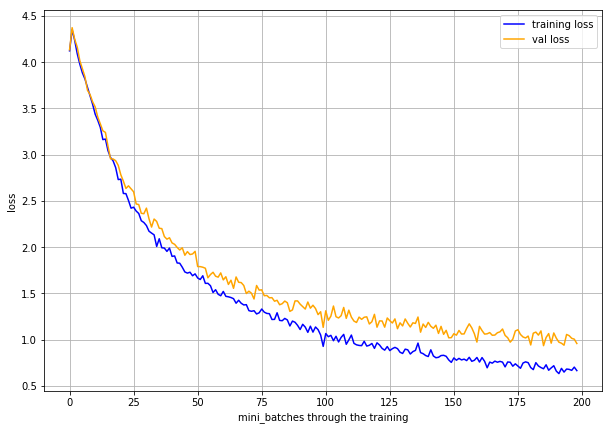

In [18]:
plt.figure(figsize= (10,7))
plt.grid(True)
plt.plot(np.array(new_tr_loss_lis),'b',label='training loss')
plt.plot(np.array(new_val_loss_lis),'orange',label='val loss')
plt.xlabel('mini_batches through the training')
plt.ylabel('loss')
plt.legend()

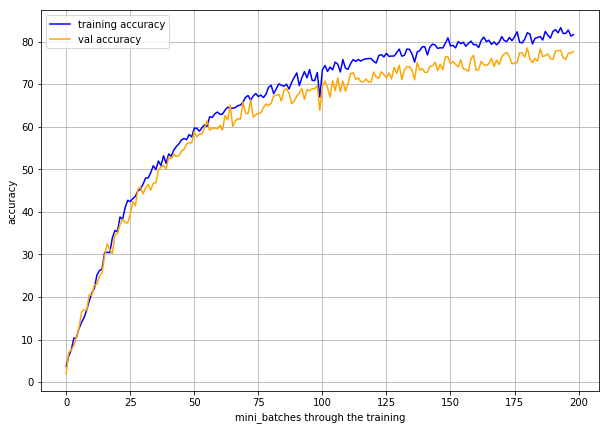

In [19]:
plt.figure(figsize= (10,7))
plt.grid(True)
plt.plot(new_tr_acc_lis,'b',label='training accuracy')
plt.plot(new_val_acc_lis,'orange',label='val accuracy')
plt.xlabel('mini_batches through the training')
plt.ylabel('accuracy')
plt.legend()